In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from collections import Counter
from scipy.stats import pearsonr

import IPython

In [2]:
data_folder = '../../output-break-infl-logreg/'
data_files = {
    'hospital': ['all-experiment-data-hospital-prop-0.1-subsets-30.npz',
                 'all-experiment-data-hospital-prop-0.1-subsets-70-random_seed-1.npz',
                 'all-experiment-data-hospital-prop-0.1-subsets-100-random_seed-2.npz',
                 'all-experiment-data-hospital-prop-0.1-subsets-100-random_seed-3-test_idx-51036.npz',
                 'all-experiment-data-hospital-prop-0.1-subsets-100-random_seed-4-test_idx-51036.npz'],
    'imageNet': ['all-experiment-data-processed_imageNet-prop-0.09-subsets-30.npz',
                 'all-experiment-data-processed_imageNet-prop-0.09-subsets-100-random_seed-1.npz']
}

all_preds, all_actuals = {'hospital': [], 'imageNet': []}, {'hospital': [], 'imageNet': []}

num_runs = {'hospital': 4+1, 'imageNet': 1+1}

def load_data(dataset_type, num=0):
    assert dataset_type in data_files.keys()
    f = np.load(os.path.join(data_folder, data_files[dataset_type][num]))
    train_losses=f['train_losses']
    test_losses=f['test_losses']
    pred_infl=f['pred_infl']
    grad_loss=f['grad_loss']
    test_idx=f['test_idx']
    
    random_subsets=f['random_subsets']
    neg_tail_subsets=f['neg_tail_subsets']
    if 'pos_tail_subset' in f:
        pos_tail_subsets=f['pos_tail_subset']
    else:
        pos_tail_subsets=f['pos_tail_subsets']
    same_grad_subsets=f['same_grad_subsets']
    same_class_subsets=f['same_class_subsets']
    
    if 'same_features_subsets' in f:
        same_features_subsets=f['same_features_subsets']
    else:
        same_features_subsets=None
    
    # clusters for same gradient subsets
    cluster_label=f['cluster_label']
    cluster_labels=f['cluster_labels']
    
    random_train_losses=f['random_train_losses']
    random_test_losses=f['random_test_losses']
    neg_tail_train_losses=f['neg_tail_train_losses']
    neg_tail_test_losses=f['neg_tail_test_losses']
    pos_tail_train_losses=f['pos_tail_train_losses']
    pos_tail_test_losses=f['pos_tail_test_losses']
    same_grad_train_losses=f['same_grad_train_losses']
    same_grad_test_losses=f['same_grad_test_losses']
    same_class_train_losses=f['same_class_train_losses']
    same_class_test_losses=f['same_class_test_losses']
    
    if 'same_features_subsets' in f:
        same_features_train_losses=f['same_features_train_losses']
        same_features_test_losses=f['same_features_test_losses']
    else:
        same_features_train_losses,same_features_test_losses=None,None
    
    return train_losses, test_losses, pred_infl, grad_loss, test_idx, random_subsets, neg_tail_subsets,\
        pos_tail_subsets, same_grad_subsets, same_class_subsets, same_features_subsets, cluster_label,\
        cluster_labels, random_train_losses, random_test_losses, neg_tail_train_losses, neg_tail_test_losses,\
        pos_tail_train_losses, pos_tail_test_losses, same_grad_train_losses, same_grad_test_losses,\
        same_class_train_losses, same_class_test_losses, same_features_train_losses, same_features_test_losses
    
def analyze_data(dataset_type, num=0):
    def compare_pred_actual(subsets, new_test_losses, name):
        if subsets is None or subsets.shape == ():
            return
        preds = []
        for subset in subsets:
            preds.append(np.sum([pred_infl[pt] for pt in subset]))
        actuals = new_test_losses[:, test_idx] - test_losses[test_idx]
        plt.scatter(actuals, preds, alpha=0.5)
        plt.xlabel('Actual Infl')
        plt.ylabel('Pred Infl')
        plt.title(dataset_type + ' ' + str(num) + ' ' + name + ': ' + str(pearsonr(actuals, preds)[0]))
        xlim = plt.xlim()
        ylim = plt.ylim()
        low = min(xlim[0], ylim[0])
        hi = max(xlim[1], ylim[1])
        plt.plot([low, hi, 0], [low, hi, 0], alpha=0.5)
        plt.show()
        
        all_preds[dataset_type] = np.concatenate((all_preds[dataset_type],preds))
        all_actuals[dataset_type] = np.concatenate((all_actuals[dataset_type],actuals))
    
    train_losses, test_losses, pred_infl, grad_loss, test_idx, random_subsets, neg_tail_subsets,\
        pos_tail_subsets, same_grad_subsets, same_class_subsets, same_features_subsets, cluster_label,\
        cluster_labels, random_train_losses, random_test_losses, neg_tail_train_losses, neg_tail_test_losses,\
        pos_tail_train_losses, pos_tail_test_losses, same_grad_train_losses, same_grad_test_losses,\
        same_class_train_losses, same_class_test_losses, same_features_train_losses, same_features_test_losses\
        = load_data(dataset_type, num)

    compare_pred_actual(random_subsets, random_test_losses, 'Random')
    compare_pred_actual(neg_tail_subsets, neg_tail_test_losses, 'Neg Tail')
    compare_pred_actual(pos_tail_subsets, pos_tail_test_losses, 'Pos Tail')
    compare_pred_actual(same_grad_subsets, same_grad_test_losses, 'Same Gradient')
    compare_pred_actual(same_class_subsets, same_class_test_losses, 'Same Class')
    compare_pred_actual(same_features_subsets, same_features_test_losses, 'Same Features')

def do_all(dataset_type):
    assert dataset_type in data_files.keys()
    
    for i in range(num_runs[dataset_type]):
        analyze_data(dataset_type, i)
    
    plt.scatter(all_actuals[dataset_type], all_preds[dataset_type], alpha=0.5)
    plt.xlabel('Actual Infl')
    plt.ylabel('Pred Infl')
    plt.title(dataset_type + ' All: ' + str(pearsonr(all_actuals[dataset_type], all_preds[dataset_type])[0]))
    xlim = plt.xlim()
    ylim = plt.ylim()
    low = min(xlim[0], ylim[0])
    hi = max(xlim[1], ylim[1])
    plt.plot([low, hi, 0], [low, hi, 0], alpha=0.5)
    plt.show()

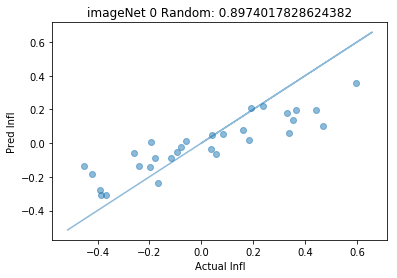

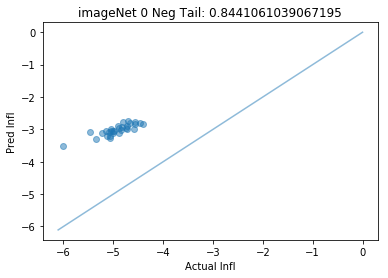

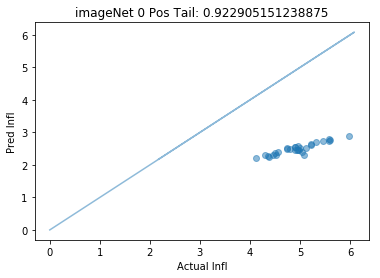

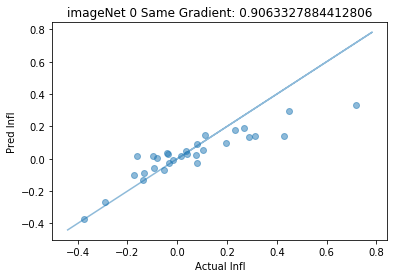

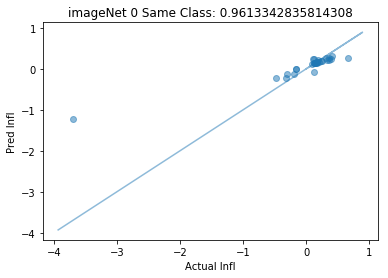

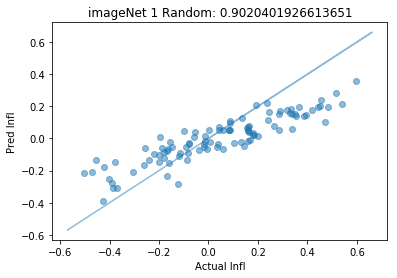

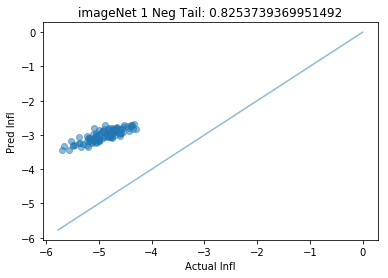

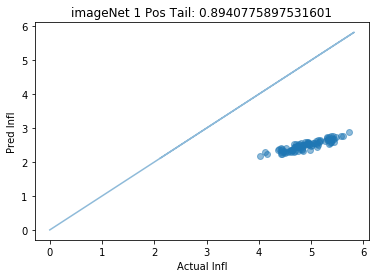

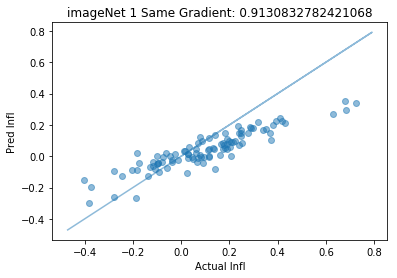

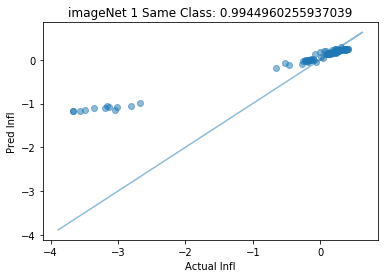

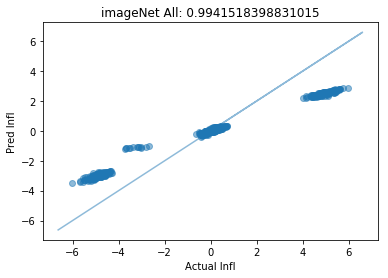

In [3]:
do_all('imageNet')

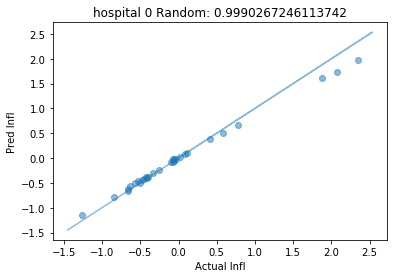

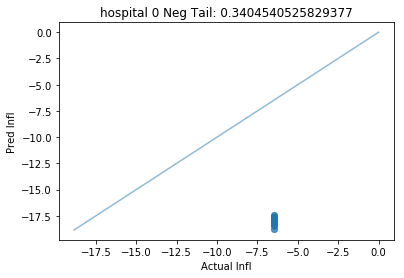

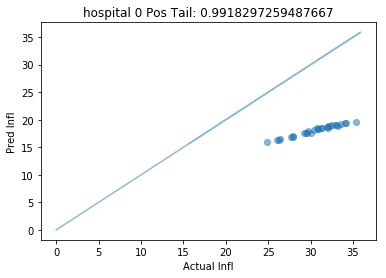

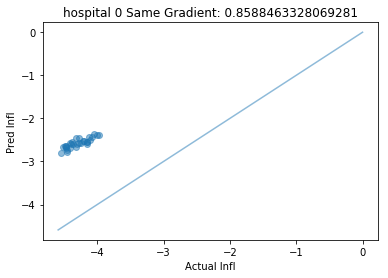

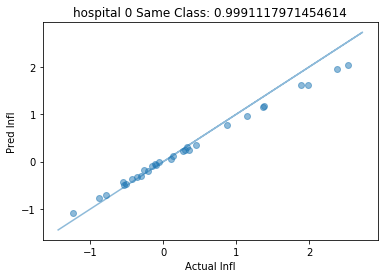

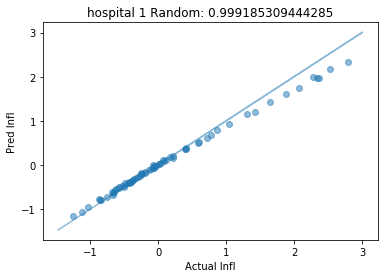

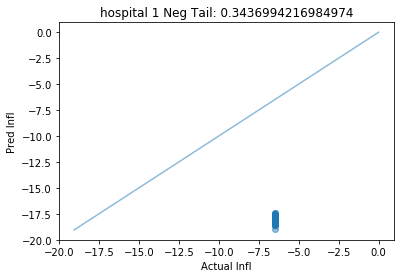

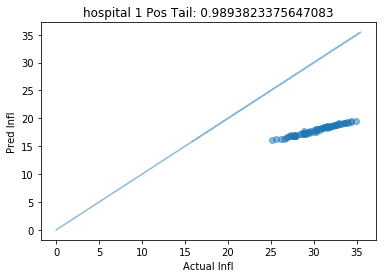

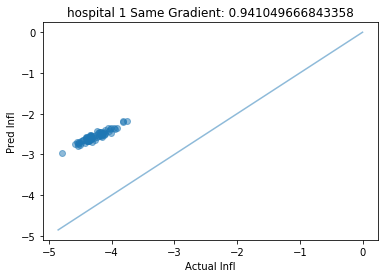

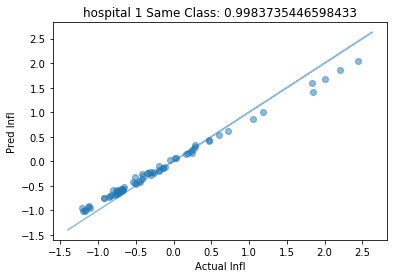

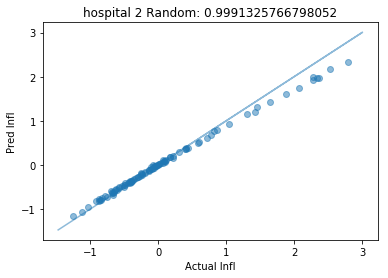

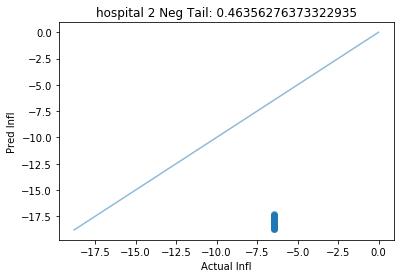

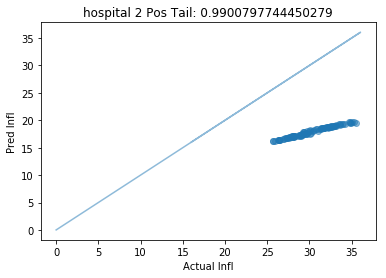

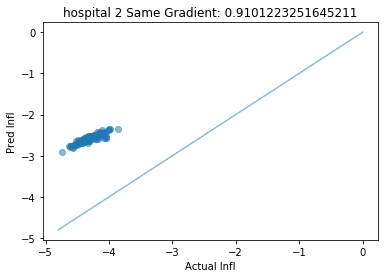

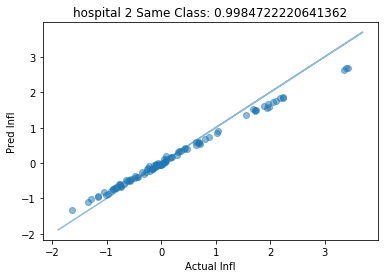

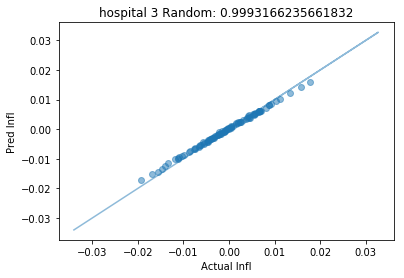

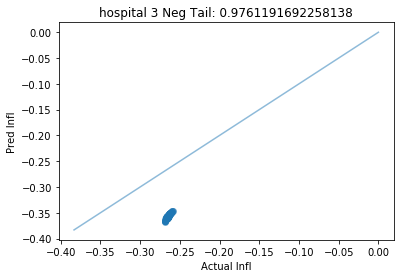

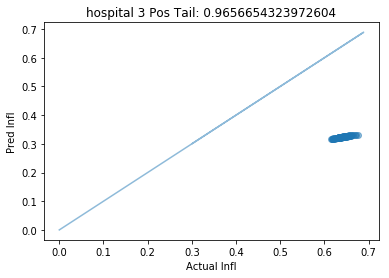

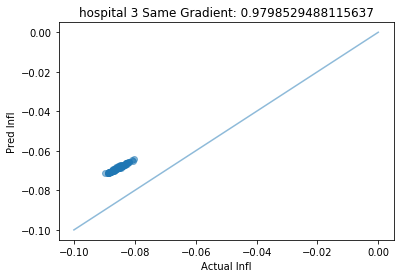

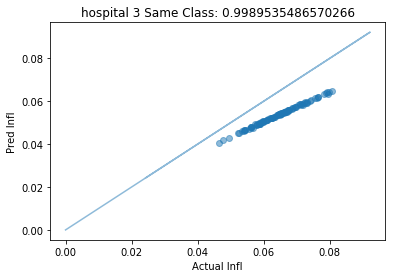

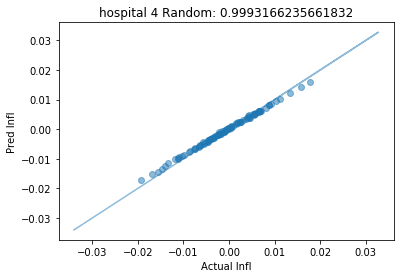

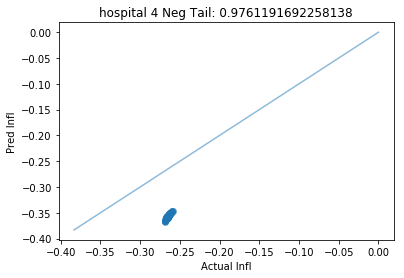

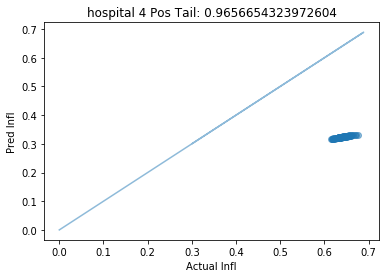

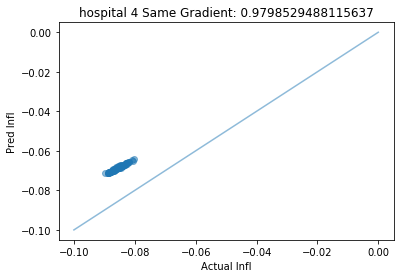

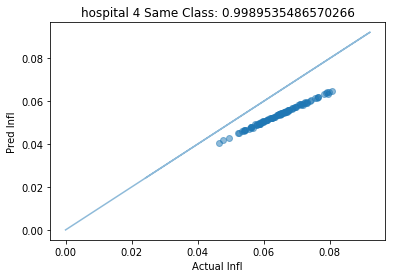

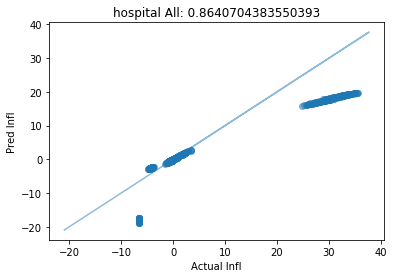

In [4]:
do_all('hospital')